In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("pyspark").getOrCreate()

In [ ]:
sc = spark.sparkContext

In [ ]:
train_df = spark.read.table("default.train")

In [ ]:
display(train_df.head(10))

id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
1.00000941815109427E18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1.0000169349117864E19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
1.000037190421512E19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
1.0000640724480838E19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
1.0000679056417042E19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157
1.0000720757801103E19,0,14102100,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,05241af0,8a4875bd,1,0,16920,320,50,1899,0,431,100077,117
1.0000724729988545E19,0,14102100,1005,0,8fda644b,25d4cfcd,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,b264c159,be6db1d7,1,0,20362,320,50,2333,0,39,-1,157
1.0000918755742329E19,0,14102100,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,e6f67278,be74e6fe,1,0,20632,320,50,2374,3,39,-1,23
1.000094927118603E19,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,37e8da74,5db079b5,1,2,15707,320,50,1722,0,35,-1,79
1.0001264480619467E19,0,14102100,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,c357dbff,f1ac7184,373ecbe6,0,0,21689,320,50,2496,3,167,100191,23


In [ ]:
click1_df = train_df.filter(train_df.click==1)
click0_df = train_df.filter(train_df.click==0)

In [ ]:
ratio = click0_df.count()/click1_df.count()
print(ratio)
fraction=1/ratio

4.717552887364208


In [ ]:
sample_df =  click0_df.sample(False,fraction)
combine_df = sample_df.unionAll(click1_df)
combine_df.groupBy("click").count().show()

+-----+-----+
|click|count|
+-----+-----+
|    0|17518|
|    1|17490|
+-----+-----+



In [ ]:
combine_df = combine_df.drop('id')

In [ ]:
from pyspark.sql.functions import countDistinct

In [ ]:
columns = combine_df.columns
for col_name in columns:
    print(col_name,":",combine_df.select(countDistinct(col_name)).show())


+---------------------+
|count(DISTINCT click)|
+---------------------+
|                    2|
+---------------------+

click : None
+--------------------+
|count(DISTINCT hour)|
+--------------------+
|                   1|
+--------------------+

hour : None
+------------------+
|count(DISTINCT C1)|
+------------------+
|                 6|
+------------------+

C1 : None
+--------------------------+
|count(DISTINCT banner_pos)|
+--------------------------+
|                         5|
+--------------------------+

banner_pos : None
+-----------------------+
|count(DISTINCT site_id)|
+-----------------------+
|                    605|
+-----------------------+

site_id : None
+---------------------------+
|count(DISTINCT site_domain)|
+---------------------------+
|                        513|
+---------------------------+

site_domain : None
+-----------------------------+
|count(DISTINCT site_category)|
+-----------------------------+
|                           15|
+-------------

In [ ]:
train,test = combine_df.randomSplit([0.8,0.2],seed=5)

In [ ]:
from pyspark.ml.feature import StringIndexer #, OneHotEncoder 

In [ ]:
cols = train.columns
print(cols)

['click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


In [ ]:
categoricalCols = cols[4:13]
print(categoricalCols)

['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


In [ ]:
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in categoricalCols]) 
#encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols]) 

In [ ]:
stringIndexerModel_train = stringIndexer.fit(train)
train_stringindexer = stringIndexerModel_train.transform(train)

In [ ]:
stringIndexerModel_test = stringIndexer.fit(test)
test_stringindexer = stringIndexerModel_test.transform(test)

In [ ]:
print(stringIndexer.getOutputCols())

['site_idIndex', 'site_domainIndex', 'site_categoryIndex', 'app_idIndex', 'app_domainIndex', 'app_categoryIndex', 'device_idIndex', 'device_ipIndex', 'device_modelIndex']


In [ ]:
# onehotencodedModel_train = encoder.fit(train_stringindexer)
# train_ohe = onehotencodedModel_train.transform(train_stringindexer)

# onehotencodedModel_test = encoder.fit(test_stringindexer)
# test_ohe = onehotencodedModel_test.transform(test_stringindexer)

In [ ]:
train_ohe.columns

Out[17]: ['click',
 'hour',
 'C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'site_idIndex',
 'site_domainIndex',
 'site_categoryIndex',
 'app_idIndex',
 'app_domainIndex',
 'app_categoryIndex',
 'device_idIndex',
 'device_ipIndex',
 'device_modelIndex',
 'site_idOHE',
 'site_domainOHE',
 'site_categoryOHE',
 'app_idOHE',
 'app_domainOHE',
 'app_categoryOHE',
 'device_idOHE',
 'device_ipOHE',
 'device_modelOHE']

In [ ]:
test_ohe.columns

Out[18]: ['click',
 'hour',
 'C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'site_idIndex',
 'site_domainIndex',
 'site_categoryIndex',
 'app_idIndex',
 'app_domainIndex',
 'app_categoryIndex',
 'device_idIndex',
 'device_ipIndex',
 'device_modelIndex',
 'site_idOHE',
 'site_domainOHE',
 'site_categoryOHE',
 'app_idOHE',
 'app_domainOHE',
 'app_categoryOHE',
 'device_idOHE',
 'device_ipOHE',
 'device_modelOHE']

In [ ]:
from pyspark.ml.feature import VectorAssembler
numericalCols = cols[1:4]+cols[13:23]
assemblerInputs = [c + "Index" for c in categoricalCols] + numericalCols
print(assemblerInputs)
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

['site_idIndex', 'site_domainIndex', 'site_categoryIndex', 'app_idIndex', 'app_domainIndex', 'app_categoryIndex', 'device_idIndex', 'device_ipIndex', 'device_modelIndex', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


In [ ]:
train_data = vecAssembler.transform(train_stringindexer)

In [ ]:
display(train_stringindexer.head(1))

click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,site_idIndex,site_domainIndex,site_categoryIndex,app_idIndex,app_domainIndex,app_categoryIndex,device_idIndex,device_ipIndex,device_modelIndex
0,14102100,1001,0,51a8ceda,c4e18dd6,bcf865d9,ecad2386,7801e8d9,07d7df22,cb4cff7c,6d36c36b,f07e20f8,1,0,20153,320,50,2307,3,163,100020,61,220.0,1.0,11.0,0.0,0.0,0.0,2088.0,9516.0,13.0


In [ ]:
test_data = vecAssembler.transform(test_stringindexer)
# display(test_data.head(1))

In [ ]:
display(train_data.head(1))

click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,site_idIndex,site_domainIndex,site_categoryIndex,app_idIndex,app_domainIndex,app_categoryIndex,device_idIndex,device_ipIndex,device_modelIndex,features
0,14102100,1001,0,51a8ceda,c4e18dd6,bcf865d9,ecad2386,7801e8d9,07d7df22,cb4cff7c,6d36c36b,f07e20f8,1,0,20153,320,50,2307,3,163,100020,61,220.0,1.0,11.0,0.0,0.0,0.0,2088.0,9516.0,13.0,"Map(vectorType -> dense, length -> 22, values -> List(220.0, 1.0, 11.0, 0.0, 0.0, 0.0, 2088.0, 9516.0, 13.0, 1.41021E7, 1001.0, 0.0, 1.0, 0.0, 20153.0, 320.0, 50.0, 2307.0, 3.0, 163.0, 100020.0, 61.0))"


In [ ]:
# train_df = train_df.select('site_idOHE', 'site_domainOHE', 'site_categoryOHE', 'app_idOHE', 'app_domainOHE', 'app_categoryOHE', 'device_idOHE', 'device_ipOHE', 'device_modelOHE', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21','click')

In [ ]:
from pyspark.ml.classification import LogisticRegression 
lr = LogisticRegression(featuresCol="features", labelCol="click", regParam=1.0)

In [ ]:
lr_model = lr.fit(train_data)

In [ ]:
lr_predict = lr_model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
bcEvaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction",labelCol = "click",metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(lr_predict)}")


Area under ROC curve: 0.6531191864440287


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

mcEvaluator = MulticlassClassificationEvaluator(predictionCol = "prediction",labelCol = "click",metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(lr_predict)}")

Accuracy: 0.6218622300058377


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import numpy as np

In [ ]:
y_test = np.array(lr_predict.select("prediction").collect())
y_score = np.array(lr_predict.select("click").collect())

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

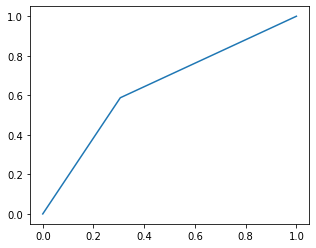

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(labelCol = "click",featuresCol = "features", maxBins=19946)

In [ ]:
dt_model = dt.fit(train_data)

In [ ]:
predictions_dt = dt_model.transform(test_data) 

In [ ]:
display(predictions_dt.head(1))

click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,site_idIndex,site_domainIndex,site_categoryIndex,app_idIndex,app_domainIndex,app_categoryIndex,device_idIndex,device_ipIndex,device_modelIndex,features,rawPrediction,probability,prediction
0,14102100,1002,0,011e5414,47bed8fe,50e219e0,ecad2386,7801e8d9,07d7df22,9bded0db,2ab5dda7,15a51a0e,0,0,16989,320,50,1926,2,39,-1,13,172.0,175.0,1.0,0.0,0.0,0.0,457.0,1463.0,544.0,"Map(vectorType -> dense, length -> 22, values -> List(172.0, 175.0, 1.0, 0.0, 0.0, 0.0, 457.0, 1463.0, 544.0, 1.41021E7, 1002.0, 0.0, 0.0, 0.0, 16989.0, 320.0, 50.0, 1926.0, 2.0, 39.0, -1.0, 13.0))","Map(vectorType -> dense, length -> 2, values -> List(9520.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0, 0.0))",0.0


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
bcEvaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction",labelCol = "click",metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predictions_dt)}")

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

mcEvaluator = MulticlassClassificationEvaluator(predictionCol = "prediction",labelCol = "click",metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(predictions_dt)}")

In [ ]:
y_test = np.array(predictions_dt.select("prediction").collect())
y_score = np.array(predictions_dt.select("click").collect())

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

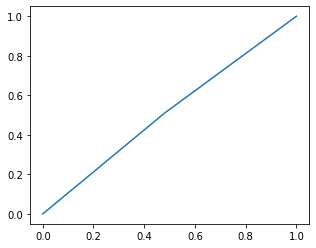

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
display(train_data.head(1))

click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,site_idIndex,site_domainIndex,site_categoryIndex,app_idIndex,app_domainIndex,app_categoryIndex,device_idIndex,device_ipIndex,device_modelIndex,features
0,14102100,1001,0,37ecc00c,c4e18dd6,110ab22d,ecad2386,7801e8d9,07d7df22,a99f214a,49741514,f07e20f8,1,0,20153,320,50,2307,3,163,100020,61,371.0,1.0,12.0,0.0,0.0,0.0,0.0,7688.0,14.0,"Map(vectorType -> dense, length -> 22, values -> List(371.0, 1.0, 12.0, 0.0, 0.0, 0.0, 0.0, 7688.0, 14.0, 1.41021E7, 1001.0, 0.0, 1.0, 0.0, 20153.0, 320.0, 50.0, 2307.0, 3.0, 163.0, 100020.0, 61.0))"


In [ ]:
rfc= RandomForestClassifier(numTrees=70,
                            maxDepth=3, 
                            labelCol='click',
                            seed=42, featuresCol='features', maxBins=19946)

In [ ]:
rfc_model= rfc.fit(train_data)

In [ ]:
rf_predict= rfc_model.transform(test_data) 

In [ ]:
bcEvaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction",labelCol = "click",metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(rf_predict)}")

Area under ROC curve: 0.5790468952549245


In [ ]:
mcEvaluator = MulticlassClassificationEvaluator(predictionCol = "prediction",labelCol = "click",metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(rf_predict)}")

Accuracy: 0.5269994162288383


In [ ]:
y_test = np.array(rf_predict.select("prediction").collect())
y_score = np.array(rf_predict.select("click").collect())

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

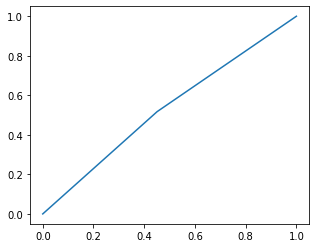

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10, featuresCol='features', labelCol='click', maxBins=17000)
gbtModel = gbt.fit(train_data)
gb_predict = gbtModel.transform(test_data)

In [ ]:
bcEvaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction",labelCol = "click",metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(gb_predict)}")

Area under ROC curve: 0.4961559974491175


In [ ]:
mcEvaluator = MulticlassClassificationEvaluator(predictionCol = "prediction",labelCol = "click",metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(gb_predict)}")

Accuracy: 0.5026269702276708


In [ ]:
## Linear SVM 

In [ ]:
from pyspark.ml.classification import LinearSVC

In [ ]:
lsvc = LinearSVC(labelCol="click",featuresCol='features' ,maxIter=50)
lsvc = lsvc.fit(train_data)

lsv_pred = lsvc.transform(test_data)

In [ ]:
bcEvaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction",labelCol = "click",metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(lsv_pred)}")

Area under ROC curve: 0.6435869035959852


In [ ]:
mcEvaluator = MulticlassClassificationEvaluator(predictionCol = "prediction",labelCol = "click",metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(lsv_pred)}")

Accuracy: 0.6171920607122008


In [ ]:
from pyspark.ml.classification import NaiveBayes

In [ ]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol='features', labelCol='click')

In [ ]:
model = nb.fit(train_data)

nb_predict = model.transform(test_data)

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-1817743344248205>:1
----> 1 model = nb.fit(train_data)
      3 nb_predict = model.transform(test_data)

File /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py:30, in _create_patch_function.<locals>.patched_method(self, *args, **kwargs)
     28 call_succeeded = False
     29 try:
---> 30     result = original_method(self, *args, **kwargs)
     31     call_succeeded = True
     32     return result

File /databricks/spark/python/pyspark/ml/base.py:205, in Estimator.fit(self, dataset, params)
    203         return self.copy(params)._fit(dataset)
    204     else:
--> 205         return self._fit(dataset)
    206 else:
    207     raise TypeError(
    208         "Params must be either a param map or a list/tuple of param maps, "
    209         "but got %s." % type(params)
    210     )

File /databri

In [ ]:
mpc_predict = model.transform(test_data)

In [ ]:
bcEvaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction",labelCol = "click",metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(mpc_predict)}")

---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
File <command-1817743344248207>:2
      1 bcEvaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction",labelCol = "click",metricName="areaUnderROC")
----> 2 print(f"Area under ROC curve: {bcEvaluator.evaluate(mpc_predict)}")

File /databricks/spark/python/pyspark/ml/evaluation.py:111, in Evaluator.evaluate(self, dataset, params)
    109         return self.copy(params)._evaluate(dataset)
    110     else:
--> 111         return self._evaluate(dataset)
    112 else:
    113     raise TypeError("Params must be a param map but got %s." % type(params))

File /databricks/spark/python/pyspark/ml/evaluation.py:148, in JavaEvaluator._evaluate(self, dataset)
    146 self._transfer_params_to_java()
    147 assert self._java_obj is not None
--> 148 return self._java_obj.evaluate(dataset._jdf)

File /databricks/spark/python/lib/py

In [ ]:
mcEvaluator = MulticlassClassificationEvaluator(predictionCol = "prediction",labelCol = "click",metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(mpc_predict)}")

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-1817743344248208>:2
      1 mcEvaluator = MulticlassClassificationEvaluator(predictionCol = "prediction",labelCol = "click",metricName="accuracy")
----> 2 print(f"Accuracy: {mcEvaluator.evaluate(mpc_predict)}")

File /databricks/spark/python/pyspark/ml/evaluation.py:111, in Evaluator.evaluate(self, dataset, params)
    109         return self.copy(params)._evaluate(dataset)
    110     else:
--> 111         return self._evaluate(dataset)
    112 else:
    113     raise TypeError("Params must be a param map but got %s." % type(params))

File /databricks/spark/python/pyspark/ml/evaluation.py:148, in JavaEvaluator._evaluate(self, dataset)
    146 self._transfer_params_to_java()
    147 assert self._java_obj is not None
--> 148 return self._java_obj.evaluate(dataset._jdf)

File /databricks/spark/python/lib/py4j-0.10.9.5-src.zi

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1817743344248209>:1
----> 1 display(train_data.head(1))

NameError: name 'train_data' is not defined

In [ ]:
from pyspark.ml.classification import FMClassifier

In [ ]:
fm = FMClassifier(factorSize=2, featuresCol='features', labelCol='click')

In [ ]:
model = fm.fit(train_data)
fmc_predict = model.transform(test_data)

In [ ]:
bcEvaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction",labelCol = "click",metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(fmc_predict)}")

Area under ROC curve: 0.47377662605166065


In [ ]:
mcEvaluator = MulticlassClassificationEvaluator(predictionCol = "prediction",labelCol = "click",metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(fmc_predict)}")

Accuracy: 0.49373177842565596


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
lr = LogisticRegression(featuresCol="features", labelCol="click", maxIter=10 )

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.05, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.5, 1.0]) \
    .build()

In [ ]:
bce = BinaryClassificationEvaluator( labelCol='click')

In [ ]:
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=bce,
                          numFolds=5) 

In [ ]:
cvModel = crossval.fit(train_data)

In [ ]:
best_prediction = cvModel.transform(test_data)

In [ ]:
mcEvaluator = MulticlassClassificationEvaluator(predictionCol = "prediction",labelCol = "click",metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(best_prediction)}")

Accuracy: 0.6151603498542274


In [ ]:
from pyspark.ml.feature import StandardScaler, PCA

In [ ]:
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(train_data)

In [ ]:
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
n_components = 4
pca = PCA(
    k = n_components,
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(train_scaled)

train_pca = pca.transform(train_scaled)
test_pca = pca.transform(test_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())

Explained Variance Ratio [0.13431356 0.12770067 0.11213353 0.09106336]


In [ ]:
display(train_pca.head(5))

click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,site_idIndex,site_domainIndex,site_categoryIndex,app_idIndex,app_domainIndex,app_categoryIndex,device_idIndex,device_ipIndex,device_modelIndex,features,scaledFeatures,pcaFeatures
0,14102100,1001,0,51a8ceda,c4e18dd6,bcf865d9,ecad2386,7801e8d9,07d7df22,cb4cff7c,6d36c36b,f07e20f8,1,0,20153,320,50,2307,3,163,100020,61,220.0,1.0,11.0,0.0,0.0,0.0,2088.0,9516.0,13.0,"Map(vectorType -> dense, length -> 22, values -> List(220.0, 1.0, 11.0, 0.0, 0.0, 0.0, 2088.0, 9516.0, 13.0, 1.41021E7, 1001.0, 0.0, 1.0, 0.0, 20153.0, 320.0, 50.0, 2307.0, 3.0, 163.0, 100020.0, 61.0))","Map(vectorType -> dense, length -> 22, values -> List(3.785779000725892, -0.2808142332548296, 7.23767933069393, -0.22248512204029075, -0.2552746561399648, -0.34211400808807935, 4.665602977132592, 0.754224861317486, -0.48611905658180454, 0.0, -3.9391010228996404, -0.513448564855312, -0.054037353647768065, -0.30788790142310013, 0.8369226724202108, 0.18166089145358044, -0.24273603328159662, 0.9403798846027484, 1.7830668231051963, 0.05740519513188017, 1.284648728629963, -0.48171874980042695))","Map(vectorType -> dense, length -> 3, values -> List(-3.0592002748653875, 5.314282129982736, -2.617864324784409))"
0,14102100,1001,0,51a8ceda,c4e18dd6,bcf865d9,ecad2386,7801e8d9,07d7df22,faef24d7,1e8e2ace,f07e20f8,1,0,17877,320,50,2036,3,47,100021,156,220.0,1.0,11.0,0.0,0.0,0.0,2493.0,5605.0,13.0,"Map(vectorType -> dense, length -> 22, values -> List(220.0, 1.0, 11.0, 0.0, 0.0, 0.0, 2493.0, 5605.0, 13.0, 1.41021E7, 1001.0, 0.0, 1.0, 0.0, 17877.0, 320.0, 50.0, 2036.0, 3.0, 47.0, 100021.0, 156.0))","Map(vectorType -> dense, length -> 22, values -> List(3.785779000725892, -0.2808142332548296, 7.23767933069393, -0.22248512204029075, -0.2552746561399648, -0.34211400808807935, 5.624448438254787, 0.021851209381900674, -0.48611905658180454, 0.0, -3.9391010228996404, -0.513448564855312, -0.054037353647768065, -0.30788790142310013, 0.13010779857982013, 0.18166089145358044, -0.24273603328159662, 0.24756681490552152, 1.7830668231051963, -0.36381805374530884, 1.2846693451139595, 1.6422259350672532))","Map(vectorType -> dense, length -> 3, values -> List(-2.7860784698700916, 5.043663591855866, -2.2564352398987806))"
0,14102100,1001,0,85f751fd,c4e18dd6,50e219e0,040daf6f,7801e8d9,7113d72a,18f60bd1,83002db4,f07e20f8,1,2,20153,320,50,2307,3,163,-1,61,1.0,1.0,1.0,167.0,0.0,14.0,636.0,10681.0,13.0,"Map(vectorType -> dense, length -> 22, values -> List(1.0, 1.0, 1.0, 167.0, 0.0, 14.0, 636.0, 10681.0, 13.0, 1.41021E7, 1001.0, 0.0, 1.0, 2.0, 20153.0, 320.0, 50.0, 2307.0, 3.0, 163.0, -1.0, 61.0))","Map(vectorType -> dense, length -> 22, values -> List(-0.2943086081704141, -0.2808142332548296, -0.16147871200911015, 4.089134428083795, -0.2552746561399648, 16.015269077969386, 1.2279644350352439, 0.9723826993397199, -0.48611905658180454, 0.0, -3.9391010228996404, -0.513448564855312, -0.054037353647768065, 2.9325041902790585, 0.8369226724202108, 0.18166089145358044, -0.24273603328159662, 0.9403798846027484, 1.7830668231051963, 0.05740519513188017, -0.7774326171596183, -0.48171874980042695))","Map(vectorType -> dense, length -> 3, values -> List(-5.77343843426303, -4.252319314351397, -6.856276174528632))"
0,14102100,1001,0,85f751fd,c4e18dd6,50e219e0,040daf6f,7801e8d9,7113d72a,c942baa3,cbafde21,f07e20f8,1,0,20153,320,50,2307,3,163,-1,61,1.0,1.0,1.0,167.0,0.0,14.0,2069.0,14391.0,13.0,"Map(vectorType -> dense, length -> 22, values -> List(1.0, 1.0, 1.0, 167.0, 0.0, 14.0, 2069.0, 14391.0, 13.0, 1.41021E7, 1001.0, 0.0, 1.0, 0.0, 20153.0, 320.0, 50.0, 2307.0, 3.0, 163.0, -1.0, 61.0))","Map(vectorType -> dense, length -> 22, values -> List(-0.2943086081704141, -0.2808142332548296, -0.16147871200911015, 4.089134428083795, -0.2552746561399648, 16.015269077969386, 4.620620103647847, 1.667117101968465, -0.48611905658180454, 0.0, -3.939101022899

In [ ]:
lr = LogisticRegression(featuresCol="pcaFeatures", labelCol="click",regParam=1.0)

In [ ]:
model = lr.fit(train_pca)

In [ ]:
lr_prediction = model.transform(test_pca)

In [ ]:
mcEvaluator = MulticlassClassificationEvaluator(predictionCol = "prediction",labelCol = "click",metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(lr_prediction)}")

Accuracy: 0.5590379008746356


In [ ]:
max_acc = 0
k=0
for i in range(1,20):
    n_components = i
    pca = PCA(k = n_components,inputCol = 'scaledFeatures', outputCol = 'pcaFeatures').fit(train_scaled)
    train_pca = pca.transform(train_scaled)
    test_pca = pca.transform(test_scaled)
    model = lr.fit(train_pca)
    lr_prediction = model.transform(test_pca)
    accuracy = mcEvaluator.evaluate(lr_prediction)
    if max_acc<accuracy:
        max_acc = accuracy
        k = i
    print(i,f"Accuracy: {accuracy}")
print(k, max_acc)

1 Accuracy: 0.5510204081632653
2 Accuracy: 0.5504373177842565
3 Accuracy: 0.5590379008746356
4 Accuracy: 0.6018950437317784
5 Accuracy: 0.601603498542274
6 Accuracy: 0.607871720116618
7 Accuracy: 0.6129737609329446
8 Accuracy: 0.6137026239067055
9 Accuracy: 0.6161807580174927
10 Accuracy: 0.6123906705539358
11 Accuracy: 0.613265306122449
12 Accuracy: 0.6145772594752187
13 Accuracy: 0.617201166180758
14 Accuracy: 0.614868804664723
15 Accuracy: 0.6158892128279884
16 Accuracy: 0.61399416909621
17 Accuracy: 0.613265306122449
18 Accuracy: 0.6145772594752187
19 Accuracy: 0.6154518950437318
13 0.617201166180758


In [ ]:
spark.stop()

In [ ]:
from pyspark.sql import SparkSession

sparkSession = (SparkSession.builder
    .master(...)
    .config("spark.jars.packages", "ai.catboost:catboost-spark_<spark_compat_version>_<scala_compat_version>:<catboost_spark_version>")
    .getOrCreate()
)

import catboost_spark


---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-659855174148196>:9
      1 from pyspark.sql import SparkSession
      3 sparkSession = (SparkSession.builder
      4     .master(...)
      5     .config("spark.jars.packages", "ai.catboost:catboost-spark_<spark_compat_version>_<scala_compat_version>:<catboost_spark_version>")
      6     .getOrCreate()
      7 )
----> 9 import catboost_spark

File /databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py:171, in _create_import_patch.<locals>.import_patch(name, globals, locals, fromlist, level)
    166 thread_local._nest_level += 1
    168 try:
    169     # Import the desired module. If you’re seeing this while debugging a failed import,
    170     # look at preceding stack frames for relevant error information.
--> 171     original_result = python_builtin_import(name, globals, locals, fromlist, 

In [ ]:
train_pool = catboost_spark.Pool(train_data.select(['features', 'click']))
train_pool.setLabelCol('click')
train_pool.setFeaturesCol('features')

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-659855174148197>:1
----> 1 train_pool = catboost_spark.Pool(train_data.select(['features', 'click']))
      2 train_pool.setLabelCol('click')
      3 train_pool.setFeaturesCol('features')

NameError: name 'catboost_spark' is not defined